خواندن فایل‌های گوگل درایو

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
import re
import spacy
from spacy import displacy
import json
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt

C:\Users\Pentium\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


باز کردن و خواندن فایل اصلی پروژه

به دلیل وجود بعضی از عبارات و حروف خوانده نمی شود utf-8

خوانده شود. زیرا در این صورت تمام کلمات و حروف غربی خوانده می شوند latin-1 بهتر است فایل به صورت 

In [3]:
with open('./content/drive/booksummaries.txt', encoding='latin-1') as f:
  text = f.read()

در ابتدا تمامی قسمت هایی که دارای مقادیر نامعتبر و نادرست هستند را به عبارت های مناسب جایگزین می کنیم

برای جایگزینی هر کدام از عبارت ها، داخل متن اصلی جست و جو شده و با توجه به مفهوم و موقعیت متن جایگزین مناسب انتخاب شده است

با عبارت ' قابل جایگزاری بودند \x19 برای مثال تمامی 

In [6]:
text = re.sub(r'\x19', "'", text)
text = re.sub(r'\x1c', '', text)
text = re.sub(r'\x13', '-', text)
text = re.sub(r'\x01', 'a', text) #a` حرف
text = re.sub(r'\x18', '"', text)
text = re.sub(r'\x0e', '', text) #حروف خاص مثل عربی و ژاپنی
text = re.sub(r'\x0f', '', text) # حروف خاص مثل d` و ...
text = re.sub(r'\x08', '', text)
text = re.sub(r'\x14', '-', text)
text = re.sub(r'\x05', '', text)
text = re.sub(r'\x02', '', text)
text = re.sub(r'\x03', 'ă', text)
text = re.sub(r'\x07', 'ć', text)
text = re.sub(r'\x15', '', text)

از آنجا که تمامی کتاب ها با الگوی زیر شروع می شودند:
عدد + \t + /m/ حرف و عدد + \t

بر اساس این الگو شروع کتاب ها را شناسایی می کنیم و آنها را از هم جدا می کنیم

In [7]:
books = re.split(r'\d+\t/m/\w+\t', text)

ساخته و هر کتاب را در سطر آن قرار می دهیم datafram یک  pandas پس از جدا سازی کتاب ها، ، با استفاده از کتابخانه 

در هر سطر چهار قسمت نام کتاب، نام نویسنده، تاریخ انتشار و متن کتاب را بر اساس فاصله(تب) از هم جدا کرده و در ستون های مربوطه قرار می دهیم

قرار داده می شود Unknown اگر مقداری برای هر کدام از داده ها وجود نداشته باشد به جای آن عبارت 

In [8]:
  def extract_info(text):
    parts = text.split('\t',4)
    book_title = parts[0] if parts[0] else "Unknown"
    author = parts[1] if parts[1] else "Unknown"
    publication_date = parts[2] if parts[2] else "Unknown"
    genres = parts[3] if parts[3] else "Unknown"
    book_text = parts[4]

    return {
        "Book Title": book_title,
        "Author": author,
        "Publication Date": publication_date,
        "Genres": genres,
        "Book Text": book_text
    }
l = []
del books[0]
for book in books:
    l.append(extract_info(book))
df = pd.DataFrame(l)


بررسی و پردازش کتاب ها بسیار آسان تر می شود dataframe با استفاده از

In [ ]:
df[df['Book Title'] == '¡Que viva la música!']

اولین مرحله برای خلاصه سازی متن کتاب ها، بررسی و اصلاح متن کتاب ها است. به گونه ای که مقادیر نامعتبر حذف یا جایگزین شوند تا فرایند خلاصه سازی بهتر صورت پذیرد

پس از بررسی فراوان متن کتاب ها. عبارات و قسمت هایی که موجب اختلال در متن کتاب می شدند پیدا کرده و آنها را اصلاح کردم

در تابع زیر که برای تمامی متن کتاب ها اجرا می شود:

را حذف کرده تا متن یک دست داشته باشیم \n ابتدا تمام تب ها و

سپس تمامی عباراتی که در متن اضافه هستند را حذف می کنیم

در متن تعدادی لینک وجود دارد که آنها را نیز حذف می کنیم

در جمله آخر بعضی از متن ها کلماتی به زبان های دیگر وجود داشت. در ابتدای این کلمات دو حرف وجود داشت که زبان را نشان می داد. تمامی این زبان ها را شناسایی کرده و از متن حذف کردم

در انتها نیز فاصله های بیش از یکی را تبدیل به یک فاصله کرده ام

In [9]:
def data_cleaner(book_text):
  # book_text = row['Book Text']



  book_text = re.sub(r'\t',' ', book_text)
  book_text = re.sub(r'\n', ' ', book_text)

  book_text = re.sub(r'\[','', book_text)
  book_text = re.sub(r'\]','', book_text)
  book_text = re.sub(r'\{.*?\}','', book_text)
  book_text = re.sub(r'\([^\)]*\)','', book_text)

  book_text = re.sub(r'https?://[^\s]*', ' ', book_text) #delete links
  book_text = re.sub(r' ar:.*','', book_text) #delete other languages
  book_text = re.sub(r' bg:.*','', book_text)
  book_text = re.sub(r' bn:.*','', book_text)
  book_text = re.sub(r' ca:.*','', book_text)
  book_text = re.sub(r' cs:.*','', book_text)
  book_text = re.sub(r' cy:.*','', book_text)
  book_text = re.sub(r' de:.*','', book_text)
  book_text = re.sub(r' eo:.*','', book_text)
  book_text = re.sub(r' es:.*','', book_text)
  book_text = re.sub(r' et:.*','', book_text)
  book_text = re.sub(r' eu:.*','', book_text)
  book_text = re.sub(r' eu:.*','', book_text)
  book_text = re.sub(r' fa:.*','', book_text)
  book_text = re.sub(r' fi:.*','', book_text)
  book_text = re.sub(r' fr:.*','', book_text)
  book_text = re.sub(r' ga:.*','', book_text)
  book_text = re.sub(r' gl:.*','', book_text)
  book_text = re.sub(r' gv:.*','', book_text)
  book_text = re.sub(r' he:.*','', book_text)
  book_text = re.sub(r' hi:.*','', book_text)
  book_text = re.sub(r' hr:.*','', book_text)
  book_text = re.sub(r' hu:.*','', book_text)
  book_text = re.sub(r' ja:.*','', book_text)
  book_text = re.sub(r' ka:.*','', book_text)
  book_text = re.sub(r' ko:.*','', book_text)
  book_text = re.sub(r' lt:.*','', book_text)
  book_text = re.sub(r' ms:.*','', book_text)
  book_text = re.sub(r' ne:.*','', book_text)
  book_text = re.sub(r' nl:.*','', book_text)
  book_text = re.sub(r' no:.*','', book_text)
  book_text = re.sub(r' no:.*','', book_text)
  book_text = re.sub(r' pa:.*','', book_text)
  book_text = re.sub(r' pl:.*','', book_text)
  book_text = re.sub(r' pt:.*','', book_text)
  book_text = re.sub(r' ro:.*','', book_text)
  book_text = re.sub(r' ru:.*','', book_text)
  book_text = re.sub(r' sk:.*','', book_text)
  book_text = re.sub(r' sr:.*','', book_text)
  book_text = re.sub(r' sv:.*','', book_text)
  book_text = re.sub(r' ta:.*','', book_text)
  book_text = re.sub(r' te:.*','', book_text)
  book_text = re.sub(r' th:.*','', book_text)
  book_text = re.sub(r' tl:.*','', book_text)
  book_text = re.sub(r' tr:.*','', book_text)
  book_text = re.sub(r' uk:.*','', book_text)
  book_text = re.sub(r' vi:.*','', book_text)
  book_text = re.sub(r' zh:.*','', book_text)
  book_text = re.sub(r' Ad:.*','', book_text)

  book_text = re.sub(r' {2,}', ' ', book_text) #delete 2 or more spaces

  return book_text

df['Book Text'] = df['Book Text'].apply(data_cleaner)# put clean book text in dataframe for each row 

سپس نیاز است تا تمام کتاب ها با طول متن کمتر از 200 حذف شوند. زیرا این متن ها داده خراب هستند

In [ ]:
df = df[df['Book Text'].str.len() > 200]

spacy بارگزاری مدل زبان انگلیسی از کتابخانه 

In [ ]:
nlp = spacy.load('en_core_web_sm')

پس از تمیز کردن متن کتاب ها نوبت به خلاصه سازی آنها می رسد

استفاده شده است facebook/bart-large-cnn برای خلاصه سازی از مدل 

در تابع زیر برای هر کتاب خلاصه ایجاد می شود و سپس در ستون خلاصه آن کتاب قرار می گیرد

در این فرایند در صورتی که طول متن از مقدار مشخصی بیشتر باشد، متن بر اساس جمله بخش بندی می شود و خلاصه هر بخش گرفته می شود. در انتها اگر همچنان طول متن تولید شده بزرگ باشد، دوبار خلاصه تولید می شود

طول متن خلاصه شده توسط این روش حدود 200 تا 400 است

In [ ]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn",device=0)#device=0 means using GPU

def split_text_by_sentences(text, chunk_size=5):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    chunks = [' '.join(sentences[i:i + chunk_size]) for i in range(0, len(sentences), chunk_size)]
    return chunks

def summarize_long_text(text):
    chunks = split_text_by_sentences(text)
    max_length = 50
    min_length = 10
    summaries = [summarizer(chunk, max_length=max_length,min_length=min_length,do_sample=False)[0]['summary_text'] for chunk in chunks]
    final_summary = ' '.join(summaries)
    while len(final_summary) >= 4500:
      final_summary = summarize_long_text(final_summary)
    if len(final_summary) >= 400:
      final_summary = summarizer(final_summary, max_length=100,do_sample=False)[0]['summary_text']
    return final_summary

def summarize_text(text):
    # اطمینان از اینکه متن خالی نیست
    if not text.strip():
        return ''

    text_length = len(text)

    if text_length >=4500:
      s = summarize_long_text(text)
    else:
      s = summarizer(text, max_length =200 , do_sample=False)[0]['summary_text']
    return s


df['Summary'] = df['Book Text'].apply(summarize_text,axis =1)

در این بخش ایست کلمات خلاصه هر کتاب حذف شده و در ستون مربوط به خود قرار می گیرد

In [ ]:
def remove_stop_words(text):
    doc = nlp(text)
    filtered_tokens = [token.text for token in doc if not token.is_stop]
    stop_words = ' '.join(filtered_tokens)
    return stop_words
    
df['Remove Stop_words'] = df['Summary'].apply(remove_stop_words,axis = 1) 

سپس نوبت به ساخت عکس از خلاصه کتاب ها می رسد 

برای ساخت عکس استفاده می کنم Stable Diffusion از مدل 

منتقل می شود GPU در این قسمت مدل براگزاری می شود. همچنان مدل را به

In [ ]:
!pip install diffusers transformers accelerate

from diffusers import StableDiffusionPipeline
import torch

#loading with GPU
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to("cuda")


در این قسمت متن خلاصه شده بدون ایست کلمه به عکس تبدیل می شود

در این پروژه به دلیل کمبود امکاناب سخت افزاری تنها 10000 کتاب خلاصه شده و عکس 1000 از آنها آماده شده است

In [ ]:
def generate_image_from_text(row,text, output_path):
    text = row['Remove Stop_words']
    
    # make image from text
    image = pipe(text).images[0]

    output_path = f'./image/{row['Book Title']}.png'
    # save image
    image.save(output_path)
    print('image saved')

df.apply(generate_image_from_text)


# اصلاح اسم کتاب و نویسنده و ژانر

در این قسمت عبارات و حروف مخرب در نام کتاب اصلاح می شود

In [25]:
def title_cleaner(title):
  title = re.sub(r'[\$\~\\]','', title)
  title = re.sub(r'.hack//','', title)
  title = re.sub(r'','P', title)
  title = re.sub(r'\n',' ', title)
  title = re.sub(r' {2,}',' ', title)
  return title

df['Book Title'] = df['Book Title'].apply(title_cleaner)

هستند اصلاح شده و از حالت نامناسب اولیه خود، به لیستی از ژانرها تبدیل می شود json در این بخش ژانر کتاب ها که به صورت

In [26]:
def genres_cleaner(genres):
  if genres != 'Unknown':
    genres = json.loads(genres)
    return list(genres.values())
  else:
    return 'Unknown'

df['Genres'] = df['Genres'].apply(genres_cleaner)

در این بخش عبارات و حروف نامناسب برای نام نویسنده شناسایی شده و اصلاح می گردد

In [27]:
def author_cleaner(author):
  author = re.sub(r'\n',' ', author)
  author = re.sub(r'[!]','.', author)
  author = re.sub(r'\+','', author)
  author = re.sub(r', \d+.*','', author)
  author = re.sub(r'»','', author)
  author = re.sub(r' "\w+"','', author)
  author = re.sub(r'\x10','D', author)
  author = re.sub(r'\x0c','', author)
  author = re.sub(r'\x1f','g', author)
  author = re.sub(r'\[','s', author)
  author = re.sub(r' \([^)]*\)','', author)
  author = re.sub(r'\)','', author)
  return author

df['Author'] = df['Author'].apply(author_cleaner)

# **بخش آماری**

In [18]:
from collections import Counter

در این بخش تعداد متن ها با طول کمتر از 200 نشان داده می شود که در واقع برای فرایند خلاصه سازی خذف می شوند

In [16]:
length_counts = {}
for index, row in df.iterrows():
    text = row['Book Text']
    length = len(text)
    if length in length_counts:
        length_counts[length] += 1
    else:
        length_counts[length] = 1
sorted_dict = {key: length_counts[key] for key in sorted(length_counts)}
sum_values = sum(value for key, value in sorted_dict.items() if key <= 200)
print('Books with length less than 200:',sum_values)



Books with length less than 200: 553


نمودارتعداد کتاب با طول مشخص شده 

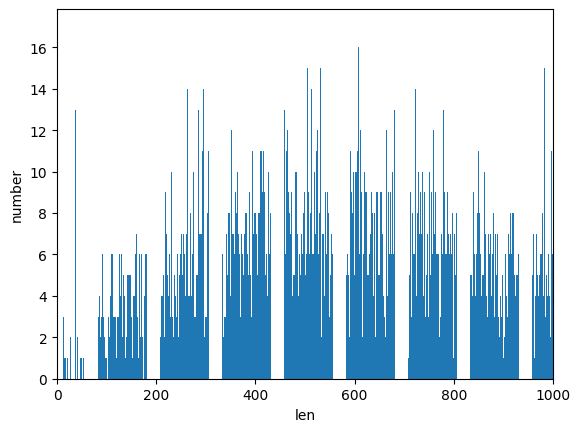

In [17]:
# Extract keys and values
keys = list(length_counts.keys())
values = list(length_counts.values())

# Create the bar plot
plt.bar(keys, values)
plt.xlim(0, 1000)
# Add labels and title
plt.xlabel('len')
plt.ylabel('number')
plt.show()

تعداد کل کتاب ها

In [20]:
len(df)

16559

تعداد مقادیر خالی در هر ستون

In [28]:
for column in df.columns:
  unknown_count = len([1 for _ , row in df.iterrows() if row[column] == 'Unknown'])
  print(f'Unknown values for {column} : {unknown_count}')

Unknown values for Book Title : 0
Unknown values for Author : 2382
Unknown values for Publication Date : 5610
Unknown values for Genres : 3718
Unknown values for Book Text : 0


تعداد ژانرهای یکتا موجود

In [29]:
df_genres_filtered = df[df['Genres'] != 'Unknown']
all_genres = [genre  for _ , row in df_genres_filtered.iterrows() for genre in row['Genres']]
unique_genres = set(all_genres)
print(f'Unique values for Genres : {len(unique_genres)}')

Unique values for Genres : 227


تعداد مقادیر یکتا برای ستون نام کتاب و نویسنده

In [30]:
for column in ['Book Title' , 'Author']:
  df_filtered = df[df[column] != 'Unknown']
  unique_data = df_filtered[column].unique()
  unique_data_count = len(unique_data)
  print(f'Unique values for {column} : {unique_data_count}')


Unique values for Book Title : 16277
Unique values for Author : 4714


ژانر هایی که هر نویسنده نوشته است

In [31]:
df_filtered = df[(df['Genres'] != 'Unknown') & (df['Author'] != 'Unknown')]
author_genres = df_filtered.groupby('Author')['Genres'].apply(lambda x: list([genre for sublist in x for genre in sublist])).reset_index()
author_genres.columns = ['Author', 'All_Genres']
author_genres['All_Genres'] = author_genres['All_Genres'].apply(lambda x : dict(Counter(x)))
author_genres

,Author,All_Genres
0,'Asta Bowen,{'Young adult literature': 1}
1,A. A. Attanasio,"{'Science Fiction': 2, 'Speculative fiction': 2}"
2,A. A. Milne,"{'Mystery': 1, 'Fiction': 1, 'Suspense': 1, 'C..."
3,A. E. W. Mason,"{'Adventure novel': 1, 'Mystery': 1, 'Detectiv..."
4,A. E. van Vogt,"{'Science Fiction': 11, 'Speculative fiction':..."
...,...,...
3857,Åke Edwardson,{'Crime Fiction': 1}
3858,Åsne Seierstad,{'Non-fiction': 1}
3859,Élisabeth Vonarburg,{'Science Fiction': 1}
3860,Émile Gaboriau,{'Detective fiction': 1}


هر نویسنده از چه ژانری بیشتر نوشته است

In [35]:
def most_genres(genres):
  counter = Counter(genres)
  max_count = max(counter.values())
  most_common_elements = [elem for elem, count in counter.items() if count == max_count]
  return most_common_elements

author_genres['Most_Genres'] = author_genres['All_Genres'].apply(most_genres)
author_genres

,Author,All_Genres,Most_Genres
0,'Asta Bowen,{'Young adult literature': 1},[Young adult literature]
1,A. A. Attanasio,"{'Science Fiction': 2, 'Speculative fiction': 2}","[Science Fiction, Speculative fiction]"
2,A. A. Milne,"{'Mystery': 1, 'Fiction': 1, 'Suspense': 1, 'C...","[Mystery, Fiction, Suspense, Children's litera..."
3,A. E. W. Mason,"{'Adventure novel': 1, 'Mystery': 1, 'Detectiv...","[Adventure novel, Mystery, Detective fiction]"
4,A. E. van Vogt,"{'Science Fiction': 11, 'Speculative fiction':...",[Science Fiction]
...,...,...,...
3857,Åke Edwardson,{'Crime Fiction': 1},[Crime Fiction]
3858,Åsne Seierstad,{'Non-fiction': 1},[Non-fiction]
3859,Élisabeth Vonarburg,{'Science Fiction': 1},[Science Fiction]
3860,Émile Gaboriau,{'Detective fiction': 1},[Detective fiction]


بیشترین و کمترین ژانر استفاده شده

In [37]:
counter = Counter(all_genres)
max_count = max(counter.values())
min_count = min(counter.values())
most_repeated = max(counter, key=counter.get)
least_repeated = min(counter, key=counter.get)
print(f'most used genres : {most_repeated}, repeated {max_count} times')
print(f'least used genres : {least_repeated}, repeated {min_count} times')

most used genres : Fiction, repeated 4747 times
least used genres : Computer Science, repeated 1 times


نموداری از تعداد دفعات استفاده از ژانز ها

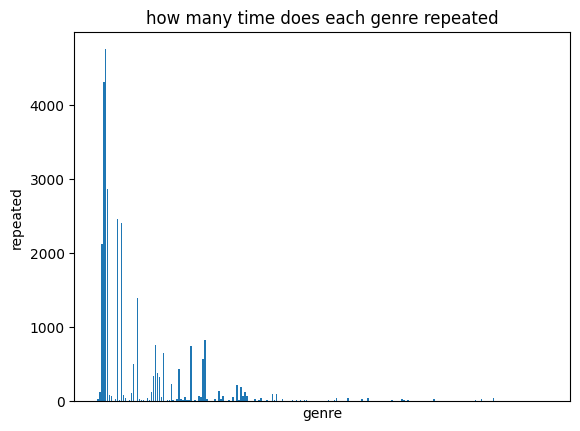

In [38]:
items = list(counter.keys())
counts = list(counter.values())

plt.bar(items, counts)
plt.xlabel('genre')
plt.ylabel('repeated')
plt.title('how many time does each genre repeated')
plt.xticks([])
plt.show()

کتاب نویسنده بیشترین کتاب را نوشتند

In [40]:
counter = Counter(df[df['Author'] != 'Unknown']['Author'])
max_count = max(counter.values())
min_count = min(counter.values())
most_repeated = max(counter, key=counter.get)
least_repeated = min(counter, key=counter.get)
print(f'most is {most_repeated} with {max_count} books')
print(f'least is {least_repeated} with {min_count} books')

most is Agatha Christie with 74 books
least is Arthur Laurents with 1 books


نمودار تعداد کتاب هر نویسنده

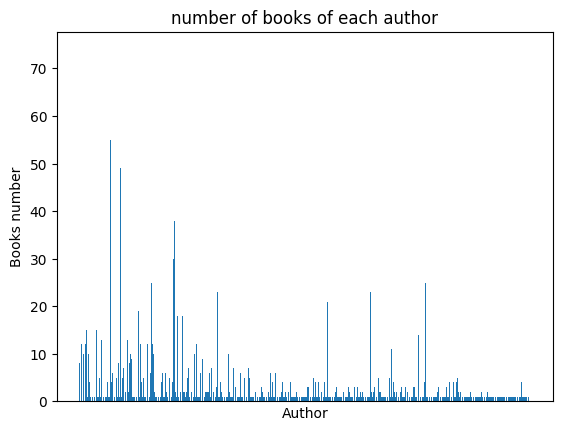

In [41]:
items = list(counter.keys())
counts = list(counter.values())

plt.bar(items, counts)
plt.xlabel('Author')
plt.ylabel('Books number')
plt.title('number of books of each author')
plt.xticks([])
plt.show()

هر سال چند کتاب منتشر شده است

In [43]:
years =[date[:4] for date in df[df['Publication Date'] != 'Unknown']['Publication Date']]
counter = Counter(years)
max_count = max(counter.values())
min_count = min(counter.values())
most_repeated = max(counter, key=counter.get)
least_repeated = min(counter, key=counter.get)
print(f'most year : {most_repeated}, Published {max_count} times')
print(f'least year : {least_repeated}, Published {min_count} times')

most year : 2007, Published 466 times
least year : 1759, Published 1 times


نمودار تعداد کتاب در هر سال

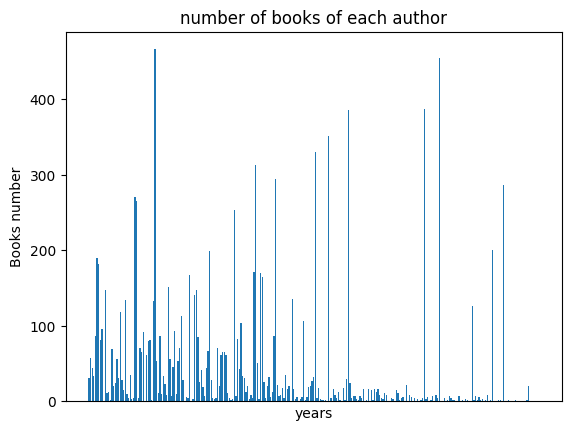

In [44]:
items = list(counter.keys())
counts = list(counter.values())

plt.bar(items, counts)
plt.xlabel('years')
plt.ylabel('Books number')
plt.title('number of books of each author')
plt.xticks([])
plt.show()

قدیمی ترین و جدید ترین کتاب ها 

In [45]:
years = set(years)
years = sorted(years)
print(f'fist year of Publication year : {years[0]}, Book name : The Confessions of St. Augustine')
print(f'last year of Publication year : {years[-1]}, Book name : Dr. Sleep')

fist year of Publication year : 0398, Book name : The Confessions of St. Augustine
last year of Publication year : 2013, Book name : Dr. Sleep
